In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import requests


In [2]:
# Your NewsAPI key
NEWS_API_KEY = 'f9b0eabb143d40b38607839bed9562db'

# Function to calculate slope between two points
def calculate_slope(price1, price2, time_diff):
    return (price2 - price1) / time_diff

# Function to detect spikes with editable thresholds
def detect_spikes(prices, timestamps, slope_threshold=9, pip_threshold=750, value_threshold=7.2, span_minutes=30):
    spikes = []
    time_window = timedelta(minutes=span_minutes)
    
    for i in range(len(prices)):
        start_time = timestamps[i] - time_window
        end_time = timestamps[i]
        time_window_data = [(timestamps[j], prices[j]) for j in range(len(prices)) if start_time <= timestamps[j] <= end_time]
        
        if len(time_window_data) < 2:
            continue
        
        time_window_data.sort()  # Ensure data is sorted by time
        window_prices = [price for _, price in time_window_data]
        window_times = [time for time, _ in time_window_data]
        
        for j in range(1, len(window_prices)):
            time_diff = (window_times[j] - window_times[j-1]).total_seconds() / 60
            slope = calculate_slope(window_prices[j-1], window_prices[j], time_diff)
            pip_change = abs(window_prices[j] - window_prices[j-1]) * 10000  # Convert to pips
            value_change = abs(window_prices[j] - window_prices[j-1])
            
            if (slope > slope_threshold and pip_change > pip_threshold) or value_change > value_threshold:
                spikes.append((timestamps[i], prices[i], slope, pip_change, value_change))
    
    return spikes

# Function to fetch minute-level data in chunks
def fetch_data(symbol="GC=F", start_date="2024-07-18", end_date="2024-08-18"):
    all_data = []
    current_start = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    while current_start < end_date:
        current_end = min(current_start + timedelta(days=7), end_date)
        data = yf.download(symbol, start=current_start.strftime('%Y-%m-%d'), end=current_end.strftime('%Y-%m-%d'), interval="5m")
        if not data.empty:
            all_data.append(data)
        current_start = current_end

    if all_data:
        combined_data = pd.concat(all_data)
        # Ensure the index is timezone-naive
        combined_data.index = combined_data.index.tz_localize(None)
        return combined_data
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data was collected

# Function to plot data and highlight spikes
def plot_data_with_spikes(data, spikes, average_spike_time, date_str):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Gold Price (GC=F)', color='blue')

    # Highlight spikes
    spike_times = [spike[0] for spike in spikes]
    spike_prices = [spike[1] for spike in spikes]
    
    plt.scatter(spike_times, spike_prices, color='red', marker='o', s=100, label='Detected Spikes')
    
    for spike in spikes:
        plt.axvline(x=spike[0], color='red', linestyle='--', lw=1)
        plt.text(spike[0], spike[1], f'Spike: {spike[4]:.2f} USD\nSlope: {spike[2]:.2f}', color='red')

    if average_spike_time:
        plt.axvline(x=average_spike_time, color='green', linestyle='-', lw=1, label='Average Spike Time')
    
    plt.legend()
    plt.title(f"Gold Price on {date_str} with Spikes Highlighted")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

# Function to fetch news articles published before a spike
def fetch_news(query, spike_time, hours_before_spike=2):
    from_time = spike_time - timedelta(hours=hours_before_spike)
    url = f'https://newsapi.org/v2/everything'
    params = {
        'q': query,
        'from': from_time.strftime('%Y-%m-%dT%H:%M:%S'),
        'to': spike_time.strftime('%Y-%m-%dT%H:%M:%S'),
        'apiKey': NEWS_API_KEY
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    if data['status'] == 'ok':
        articles = data['articles']
        return articles
    else:
        print("Failed to fetch news:", data.get('message', 'Unknown error'))
        return []


In [3]:
# Function to analyze data, plot spikes, and fetch related news
def analyze_date(date_str, symbol="GC=F", slope_threshold=9, pip_threshold=750, value_threshold=4):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    start_date = (date - timedelta(days=30)).strftime('%Y-%m-%d')
    end_date = (date + timedelta(days=1)).strftime('%Y-%m-%d')
    
    # Fetch data for the past month in chunks
    data = fetch_data(symbol=symbol, start_date=start_date, end_date=end_date)
    
    if data.empty:
        print(f"No data found for {date_str}.")
        return

    # Filter data for the specific date
    date = date.replace(tzinfo=None)  # Ensure date is timezone-naive
    data_on_date = data.loc[date.date():date.date() + timedelta(days=1)]

    if data_on_date.empty:
        print(f"No data found for {date_str}.")
        return

    # Detect spikes with the provided thresholds
    prices = data_on_date['Close'].tolist()
    timestamps = data_on_date.index.to_pydatetime()
    spikes = detect_spikes(prices, timestamps, slope_threshold, pip_threshold, value_threshold)

    if spikes:
        print(f"Spikes detected on {date_str}:")
        for spike in spikes:
            print(f" - Time: {spike[0]}, Price: {spike[1]}, Slope: {spike[2]:.2f}, Pips: {spike[3]:.0f}, Value Change: {spike[4]:.2f} USD")
        
        # Calculate average spike time
        average_spike_time = np.mean([spike[0].timestamp() for spike in spikes])
        average_spike_time = datetime.fromtimestamp(average_spike_time)

        print(f"Average spike time: {average_spike_time}")

        # Fetch news related to the spikes published before the spike time
        for spike in spikes:
            spike_time = spike[0]
            news = fetch_news("gold price", spike_time, hours_before_spike=2)

            if news:
                print(f"News articles related to the spike at {spike_time}:")
                for article in news:
                    print(f" - {article['title']}: {article['description']} ({article['url']})")
            else:
                print(f"No news articles found for the spike at {spike_time}.")
    else:
        print(f"No significant spikes detected on {date_str}.")
        average_spike_time = None
    
    # Plot data with spikes highlighted
    plot_data_with_spikes(data_on_date, spikes, average_spike_time, date_str)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Spikes detected on 2024-08-14:
 - Time: 2024-08-14 20:10:00, Price: 2479.699951171875, Slope: -0.75, Pips: 75000, Value Change: 7.50 USD
 - Time: 2024-08-14 20:15:00, Price: 2486.89990234375, Slope: -0.75, Pips: 75000, Value Change: 7.50 USD
 - Time: 2024-08-14 20:20:00, Price: 2486.60009765625, Slope: -0.75, Pips: 75000, Value Change: 7.50 USD
 - Time: 2024-08-14 20:25:00, Price: 2487.5, Slope: -0.75, Pips: 75000, Value Change: 7.50 USD
 - Time: 2024-08-14 20:30:00, Price: 2488.699951171875, Slope: -0.75, Pips: 75000, Value Change: 7.50 USD
Average spike time: 2024-08-14 20:20:00
News articles related to the spike at 2024-08-14 20:10:00:
 - A rosé by any other name: Veteran Boston tech entrepreneurs launch winemaking business: Even for Amy and Pierre Villenueve, a couple hardened by years of starting, running, and working in tech startups, winemaking presented a new set of risks. (https://www.bostonglobe.com/2024/08/14/business/domaine-travelle-wine-vineyard-france-rose-amy-pierre-vil

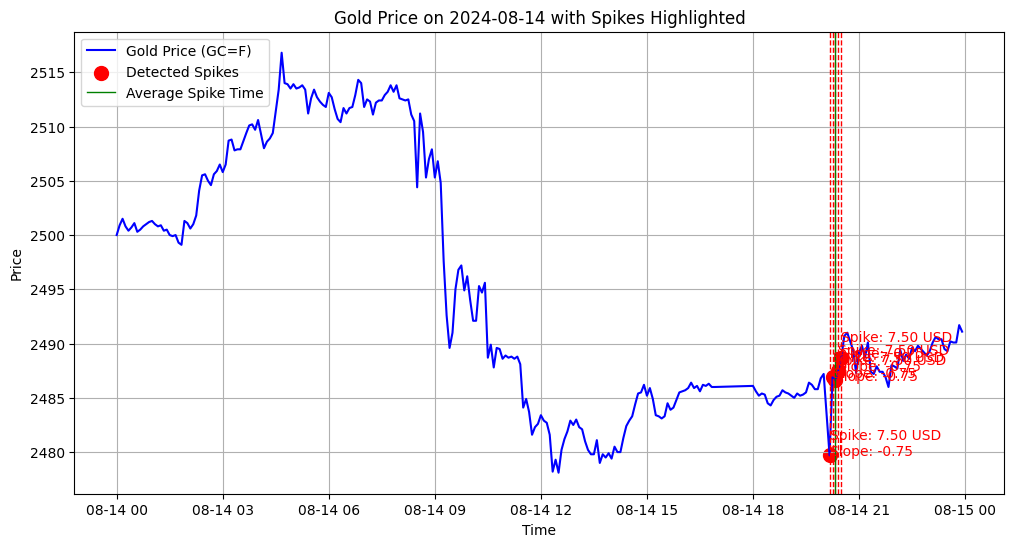

In [4]:
# Example usage: Analyze data, plot spikes, and fetch related news for a specific date with custom thresholds
date_input = "2024-08-14"  # Example date
slope_threshold = 9  # Editable slope threshold
pip_threshold = 750  # Editable pip threshold
value_threshold = 7.2  # Editable value threshold
analyze_date(date_input, slope_threshold=slope_threshold, pip_threshold=pip_threshold, value_threshold=value_threshold)
